Columns with only missing values: ['local_orig']
detailed-label
C&C                          6706
DDoS                         5757
-                            1923
PartOfAHorizontalPortScan     122
Name: count, dtype: int64
label
Malicious    3860
Benign       1923
Name: count, dtype: int64
detailed-label
C&C                          2023
-                            1923
DDoS                         1715
PartOfAHorizontalPortScan     122
Name: count, dtype: int64
5784
5783
Training set distribution:
label
0.0    1912
1.0     979
Name: count, dtype: int64

Testing set distribution:
label
0.0    1948
1.0     944
Name: count, dtype: int64
Train data saved to 'train_data.csv'.
Test data saved to 'test_data.csv'.
Index(['id.orig_h_192.168.1.1', 'id.orig_h_192.168.1.195', 'id.resp_h_1.1.1.1',
       'id.resp_h_104.238.179.228', 'id.resp_h_109.224.76.139',
       'id.resp_h_123.59.209.185', 'id.resp_h_136.243.177.133',
       'id.resp_h_146.0.32.144', 'id.resp_h_147.231.100.5',
       'id.

/home/diogo/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


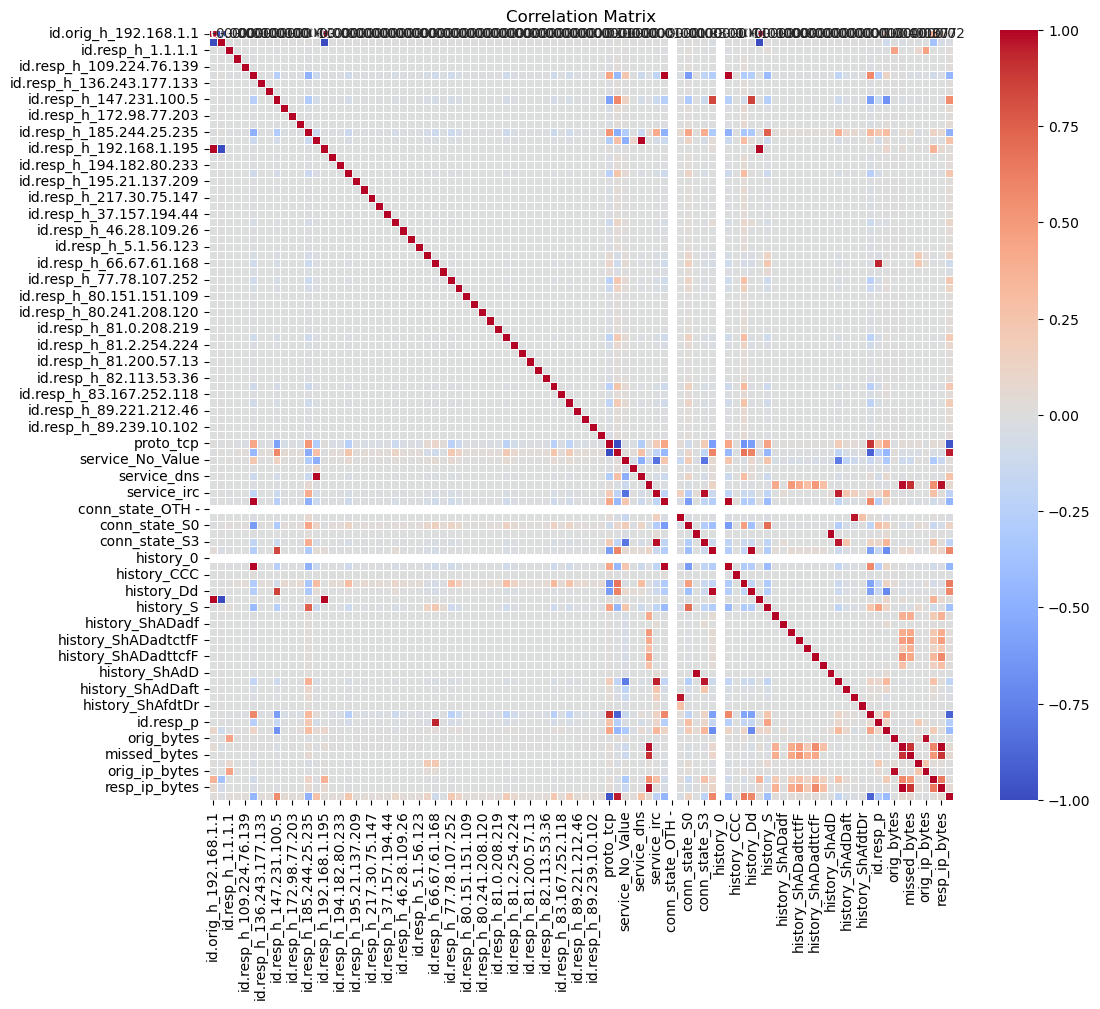

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Define the file path
file_path = 'conn.log.labeled'

# Manually define the expected column names
column_names = [
    "ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", "proto",
    "service", "duration", "orig_bytes", "resp_bytes", "conn_state",
    "local_orig", "local_resp", "missed_bytes", "history", "orig_pkts",
    "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "tunnel_parents"
]

# Read the file
df = pd.read_csv(
    file_path,
    sep="\t",  # Separator is tab
    comment="#",  # Skip lines starting with '#'
    header=None,  # No header in data section
    skip_blank_lines=True  # Avoid blank lines
)

# Add placeholder columns if fewer than expected
while df.shape[1] < len(column_names):
    df[df.shape[1]] = "-"

# Assign column names
df.columns = column_names

# Replace `-` with NaN for better handling of missing data
df.replace("-", pd.NA, inplace=True)

# Check which columns have only NaN values
all_na_columns = df.columns[df.isna().all()].tolist()
print(f"Columns with only missing values: {all_na_columns}")

# Optionally drop columns with only NaN
df.drop(columns=all_na_columns, inplace=True)

# Handle 'tunnel_parents' column to split space-separated values
df[['tunnel_parents', 'label', 'detailed-label']] = df['tunnel_parents'].str.split(r'\s+', n=2, expand=True)

# Contar a quantidade de cada tipo de 'detailed-label'
detailed_label_counts = df['detailed-label'].value_counts()

# Verificar a quantidade da classe majoritária (DDoS)
ddos_count = detailed_label_counts['DDoS']

# Verificar a quantidade de dados da classe minoritária
minority_class_size = len(df[df['detailed-label'] != 'DDoS'])

# Definir o percentual de redução da classe DDoS
percentage_reduction = 0.6 # Exemplo: reduzir 50% da classe DDoS

# Calcular o número de amostras a serem mantidas na classe DDoS
ddos_undersample_size = int(ddos_count * (1 - percentage_reduction))

# Realizar undersampling na classe DDoS para a quantidade calculada
df_ddos_undersampled = df[df['detailed-label'] == 'DDoS'].sample(ddos_undersample_size, random_state=42)

# Manter a parte dos dados que não são DDoS
df_other = df[df['detailed-label'] != 'DDoS']

# Concatenar as duas partes balanceadas
df_balanced = pd.concat([df_ddos_undersampled, df_other])

# Embaralhar o DataFrame final para aleatorizar os dados
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Exibir a nova distribuição
print(df_balanced['detailed-label'].value_counts())

# Contar a quantidade de cada tipo de 'label'
detailed_label_counts = df_balanced['label'].value_counts()

# Verificar a quantidade da classe majoritária (Malicious)
malicious_count = detailed_label_counts['Malicious']

# Verificar a quantidade de dados da classe minoritária (Benign)
benign_count = detailed_label_counts['Benign']

# Definir o percentual de redução da classe Malicious
percentage_reduction_malicious = 0.7  # Exemplo: reduzir 70% da classe Malicious

# Dividir os dados da classe Malicious em duas partes:
# 1. Parte com detailed_label = 'PartOfAHorizontalPortScan'
df_malicious_partscan = df_balanced[(df_balanced['label'] == 'Malicious') & 
                                    (df_balanced['detailed-label'] == 'PartOfAHorizontalPortScan')]

# 2. Parte restante da classe Malicious (sem 'PartOfAHorizontalPortScan')
df_malicious_others = df_balanced[(df_balanced['label'] == 'Malicious') & 
                                   (df_balanced['detailed-label'] != 'PartOfAHorizontalPortScan')]

# Calcular o número de amostras a serem mantidas na parte restante da classe Malicious
malicious_undersample_size = int(df_malicious_others.shape[0] * (1 - percentage_reduction_malicious))

# Realizar undersampling na parte restante da classe Malicious
df_malicious_undersampled = df_malicious_others.sample(malicious_undersample_size, random_state=42)

# Manter a parte dos dados que não são Malicious
df_other = df_balanced[df_balanced['label'] != 'Malicious']

# Concatenar a parte não alterada de 'PartOfAHorizontalPortScan', 
# a parte reduzida de Malicious e os dados de outras classes
df_balanced = pd.concat([df_malicious_partscan, df_malicious_undersampled, df_other])

# Embaralhar o DataFrame final para aleatorizar os dados
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Exibir a nova distribuição
print(df_balanced['label'].value_counts())

# Mostrar gráficos novamente para verificar a distribuição balanceada
detailed_label_counts_balanced = df_balanced['label'].value_counts()
print(df_balanced['detailed-label'].value_counts())

df_balanced.drop(columns=['ts','uid','detailed-label','tunnel_parents'], inplace=True)

df_balanced['label'] = df_balanced['label'].replace({'Malicious': 0, 'Benign': 1})






# Replace <NA> with np.nan in 'duration' column
df_balanced['duration'] = df_balanced['duration'].replace({pd.NA: np.nan})

# Step 1: Impute missing values in the 'duration' column (impute before transformation)
imputer = SimpleImputer(strategy='median')
df_balanced['duration'] = imputer.fit_transform(df_balanced[['duration']])

# Step 2: Apply the log transformation to the 'duration' column
df_balanced['duration'] = df_balanced['duration'].apply(lambda x: np.log(x + 1) if x > 0 else 0)

# Step 3: Standardize the 'duration' column
scaler = StandardScaler()
df_balanced['duration'] = scaler.fit_transform(df_balanced[['duration']])





# Replace NA values with an empty string (or any placeholder you prefer) in the columns
columns_to_encode = ['id.orig_h', 'id.resp_h', 'proto', 'service','conn_state','history']

# Replace NA values with 'No_Value'
df_balanced[columns_to_encode] = df_balanced[columns_to_encode].replace({pd.NA: 'No_Value'})

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the selected columns
encoded_columns = encoder.fit_transform(df_balanced[columns_to_encode])

# Convert the encoded columns to a DataFrame
encoded_columns_df = pd.DataFrame(
    encoded_columns, 
    columns=encoder.get_feature_names_out(columns_to_encode)
)

# Concatenate the one-hot encoded columns at the beginning of the original DataFrame
df_balanced_encoded = pd.concat([encoded_columns_df, df_balanced], axis=1)

# Optionally drop the original columns that were encoded
df_balanced_encoded.drop(columns=columns_to_encode, inplace=True)


# Ensure columns are numeric before filling NaNs
df_balanced_encoded['orig_bytes'] = pd.to_numeric(df_balanced_encoded['orig_bytes'], errors='coerce')
df_balanced_encoded['resp_bytes'] = pd.to_numeric(df_balanced_encoded['resp_bytes'], errors='coerce')

# Fill missing values with mean for numeric columns (assigning back to the column)
df_balanced_encoded['orig_bytes'] = df_balanced_encoded['orig_bytes'].fillna(df_balanced_encoded['orig_bytes'].mean())
df_balanced_encoded['resp_bytes'] = df_balanced_encoded['resp_bytes'].fillna(df_balanced_encoded['resp_bytes'].mean())

# For categorical columns, use the mode instead (assigning back to the column)
df_balanced_encoded['local_resp'] = df_balanced_encoded['local_resp'].fillna(df_balanced_encoded['local_resp'].mode()[0])
df_balanced_encoded['label'] = df_balanced_encoded['label'].fillna(df_balanced_encoded['label'].mode()[0])

# Calculate the mode of the 'missed_bytes' column
mode_value = df_balanced_encoded['missed_bytes'].mode()[0]

# Replace 'C' with the mode value
df_balanced_encoded['missed_bytes'] = df_balanced_encoded['missed_bytes'].replace('C', mode_value)


#Remove row with column "resp_ip_bytes" = "-   Malicious   DDoS"
df_balanced_encoded = df_balanced_encoded[df_balanced_encoded['resp_ip_bytes'] != '-   Malicious   DDoS']



# Split the data into 50% train and 50% test
train_df, test_df = train_test_split(df_balanced_encoded, test_size=0.5, random_state=42)

# Check the distribution in train and test sets
print("Training set distribution:")
print(train_df['label'].value_counts())

print("\nTesting set distribution:")
print(test_df['label'].value_counts())

# Save the test DataFrame to a CSV file
train_df.to_csv('train_data.csv', index=False)
print("Train data saved to 'train_data.csv'.")

test_df.to_csv('test_data.csv', index=False)
print("Test data saved to 'test_data.csv'.")


#Print the name of the columns
print(train_df.columns)



# Now, calculate the correlation matrix again
correlation_matrix = df_balanced_encoded.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

